In [1]:
# Use the best model for each checkpoint folder to test maes for all data folds

In [2]:
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
from pathlib import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [3]:
args = argparse.Namespace()
args.gazeMpiimage_dir = '/project/data/Image'  #real data 
args.gazeMpiilabel_dir = '/project/data/Label'  #real label
# args.output = '/project/results/soutput1/snapshots/'
args.dataset = 'mpiigaze'
args.snapshot='/project/results/soutput2/snapshots/'
# args.evalpath = '/project/results/sroutput1/evaluation/'
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=35
args.angle = 180
args.bin_width = 4


In [4]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
# evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width
gazeMpiimage_dir = args.gazeMpiimage_dir
gazeMpiilabel_dir=args.gazeMpiilabel_dir

In [5]:
# args = parse_args()
cudnn.enabled = True
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used= getArch(arch, bins)  #resnet50 and 28 bins

In [6]:
#read the fold epoch table
dfile = Path(snapshot_path).parent/"syn_syn_sdata2_all_MAE.npy"
all_MAE = np.load(dfile)
best_epoch = {}
best_epoch_error = {}
print(f"fold   best_epoch error(degree)")
for idx, fdata in enumerate(all_MAE):
#     print(idx, type(idx))
    epoch_min_error = np.argmin(fdata)+1
    print(f'{idx:^4} {np.argmin(fdata)+1:^12} {fdata.min():^11.3f}')
    best_epoch[idx+1] = epoch_min_error
    best_epoch_error[idx+1]=fdata.min()

fold   best_epoch error(degree)
 0        47         2.902   
 1        55         2.718   
 2        56         3.145   
 3        57         3.704   
 4        52         3.123   
 5        51         2.578   
 6        58         3.239   
 7        55         2.979   
 8        47         4.673   
 9        32         4.767   
 10       26         2.979   
 11       53         2.528   
 12       10         3.276   
 13       54         2.488   
 14       11         3.323   


In [7]:
# check if we have the correct number of checkpoint files 
ppath = snapshot_path
for fold in range(15):
    foldstr = f"fold{fold:0>2}"
    cpath =os.path.join(ppath, foldstr)
    files = os.listdir(cpath)
    print(f'{fold}:{len(files)}',end=" ")

0:60 1:60 2:60 3:60 4:60 5:60 6:60 7:60 8:60 9:60 10:60 11:60 12:60 13:60 14:60 

In [8]:
def get_now():
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format) 
    return now
print(get_now())

07/14/2022 06:36:51


In [9]:
%%time
# all_MAE = []
# tosave={}
lfolder = os.listdir(gazeMpiilabel_dir)
lfolder.sort()  #individual label files
testlabelpathcombined = [os.path.join(gazeMpiilabel_dir, j) for j in lfolder] 
print(testlabelpathcombined)
model = model_used
model= nn.DataParallel(model,device_ids=[0])  #important to load state dict
# for cfold in range(15):  #checkpoint folds
cfold=0


cfoldstr = f"fold{cfold:0>2}"
print(f"cfold={cfoldstr}")
idx = cfold + 1
b_epoch = best_epoch[idx]

checkpoint_path = Path(snapshot_path)/cfoldstr
best_checkpoint_file = 'epoch_'+str(b_epoch)+'.pkl'
best_checkpoint_file = checkpoint_path/best_checkpoint_file
#     print(best_checkpoint_file, type(best_checkpoint_file))
checkpoint = torch.load(best_checkpoint_file)
saved_state_dict = checkpoint['model_state_dict']
model.load_state_dict(saved_state_dict)

model.cuda(gpu)
model.eval()
idx_tensor = [idx for idx in range(35)]
idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
softmax = nn.Softmax(dim=1)
best_model_maes =[]  # error for each data fold


all_pitches=[]
all_pitch_errors =[]
all_yaws=[]
all_yaw_errors =[]

for dfold in range(15):  #data folds
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, gazeMpiimage_dir, transformations, False, angle, dfold)
    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True)
    now = get_now()
    configuration = f"\ntest configuration: gpu_id={gpu}, batch_size={batch_size}\n"
    configuration += f"model_arch={arch} Start testing dataset={data_set}\n"
    configuration +=  f"cFOLD={cfold} dFOLD={dfold}--{now}----"
    print(configuration)

#     total = 0  
#     avg_error = .0
    with torch.no_grad():
        for j, (images, labels, cont_labels, name) in enumerate(test_loader):
            images = Variable(images).cuda(gpu)
#             total += cont_labels.size(0)

            label_pitch = cont_labels[:,1].float()*np.pi/180
            label_yaw = cont_labels[:,0].float()*np.pi/180
            label_yaw = label_yaw*(-1.0)

            gaze_pitch, gaze_yaw = model(images)

            # Binned predictions
            _, pitch_bpred = torch.max(gaze_pitch.data, 1)
            _, yaw_bpred = torch.max(gaze_yaw.data, 1)

            # Continuous predictions
            pitch_predicted = softmax(gaze_pitch)
            yaw_predicted = softmax(gaze_yaw)

            # mapping from binned (0 to 28) to angels (-42 to 42)                
            pitch_predicted = \
                torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 52
            yaw_predicted = \
                torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 52

            label_yaw = label_yaw*180/np.pi
            label_pitch = label_pitch*180/np.pi
            
#             pitch_predicted = pitch_predicted
#             yaw_predicted = yaw_predicted
            
            pitch_errors = pitch_predicted - label_pitch
            yaw_errors = yaw_predicted - label_yaw
            
            all_yaws.extend(label_yaw.numpy())
            all_pitches.extend(label_pitch.numpy())
            all_yaw_errors.extend(yaw_errors.numpy())
            all_pitch_errors.extend(pitch_errors.numpy())
            if j == 2:
                print(f"pitches:{label_pitch}")
                print(f"yaws:{label_yaw}")
                print(f"pitches_predicted:{pitch_predicted}")
                print(f"yaws_predicted:{yaw_predicted}")
                print(f"pitches_errors:{pitch_errors}")
                print(f"yaws_errors:{yaw_errors}")


['/project/data/Label/p00.label', '/project/data/Label/p01.label', '/project/data/Label/p02.label', '/project/data/Label/p03.label', '/project/data/Label/p04.label', '/project/data/Label/p05.label', '/project/data/Label/p06.label', '/project/data/Label/p07.label', '/project/data/Label/p08.label', '/project/data/Label/p09.label', '/project/data/Label/p10.label', '/project/data/Label/p11.label', '/project/data/Label/p12.label', '/project/data/Label/p13.label', '/project/data/Label/p14.label']
cfold=fold00
0 items removed from dataset that have an angle > 180

test configuration: gpu_id=cuda:0, batch_size=20
model_arch=ResNet50 Start testing dataset=mpiigaze
cFOLD=0 dFOLD=0--07/14/2022 06:36:56----
pitches:tensor([-13.6999, -10.8950,  -0.3938,  -7.8972,  -1.2028,  -8.6839,  -8.5490,
         -8.3595,  -7.8905,  -8.9074,  -3.4585,  -9.7572,  -6.8425,  -5.9541,
         -0.8198, -10.1542,  -8.1737,  -9.4927, -14.3258,  -3.0681])
yaws:tensor([  9.2711,   3.9719,  -8.4433,  -1.3286,   8.7618,

0 items removed from dataset that have an angle > 180

test configuration: gpu_id=cuda:0, batch_size=20
model_arch=ResNet50 Start testing dataset=mpiigaze
cFOLD=0 dFOLD=5--07/14/2022 06:38:17----
pitches:tensor([ -6.8893, -14.3303, -15.3703,  -2.1513,  -6.4182, -12.8865,  -2.0761,
         -2.7951,  -5.2510,  -4.8159,  -6.5244, -11.1563,  -8.1803, -12.6986,
        -13.6187,  -3.3242,  -3.6732,  -1.8181, -10.1030,  -7.7701])
yaws:tensor([ 15.4040,   3.6918,   7.9921,   2.4595,   7.9601,  -7.5013,  -5.8316,
          5.5059,  -6.5751,   2.7961, -14.7853,   8.6173,  13.7040,   5.7870,
          2.5303,   4.5990,   5.5701,  -5.4725,   2.9493,   9.1771])
pitches_predicted:tensor([-10.2022, -14.1695, -11.5904,  -8.6308,  -3.0791, -12.1531, -12.6069,
         -4.3271,  -5.4080,  -0.6585,  -6.1574, -12.2364,  -6.8155, -12.9166,
         -7.9446,  -4.7475,   0.0691,  -1.8264,  -5.2706,  -5.7235])
yaws_predicted:tensor([  4.5788,   5.8419,  10.0003,   1.2828,  12.5090,   0.0752,  -4.6093,
     

pitches:tensor([-17.6821,  -9.4249,  -6.1706, -12.6807,  -4.9781, -15.7945,  -3.2494,
        -10.7158,  -3.9176, -13.2465,  -7.1941,  -7.7473,  -4.8662,  -3.9292,
         -7.9390, -14.7358, -16.2158,  -2.1762,  -0.4581,  -6.1706])
yaws:tensor([  0.5568,   6.7723,   7.4226,  -9.6195,  -2.5130,   5.3142,   9.3096,
         -9.6641,  -0.0742, -40.4794,  11.0368,   5.7243,   3.7587,  -9.2252,
          3.0971,   5.0168,   1.0829,  -6.3439,  12.9137,  -7.4226])
pitches_predicted:tensor([ -1.9581,  -1.6734,   1.7943,   2.4607,   0.7805,  -1.0696,   9.1309,
          1.9067,  -9.4842,   3.7498,   0.9486,  -3.0247,   5.3774,   3.0616,
         -3.7424,  -1.5661, -13.3251,   3.9027,   7.5147,   3.2277])
yaws_predicted:tensor([ 0.0585,  5.6211,  7.4270,  5.0988,  4.2813,  2.8851,  9.5418, -6.3061,
        10.8227, -9.4647,  8.0431,  6.4774,  6.9350, -8.5579,  5.2839,  3.4690,
         6.1660,  0.6565, 13.9880, -5.9282])
pitches_errors:tensor([15.7240,  7.7515,  7.9649, 15.1413,  5.7586, 14.724

In [10]:
all_yaws = np.array(all_yaws)
all_pitches = np.array(all_pitches)
all_yaw_errors = np.array(all_yaw_errors)
all_pitch_errors = np.array(all_pitch_errors)

In [11]:
# frun = wandb.init(project="54_best_smodel_all_rdata_sign_errors")
# frun.name = f'signed_errors_best_smodel_all_rdata'

(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        6.000e+00, 4.000e+00, 1.100e+01, 1.500e+01, 2.500e+01, 4.500e+01,
        7.500e+01, 1.940e+02, 4.960e+02, 1.285e+03, 2.766e+03, 4.951e+03,
        7.028e+03, 8.069e+03, 7.778e+03, 5.378e+03, 3.083e+03, 1.553e+03,
        9.480e+02, 5.480e+02, 3.170e+02, 1.820e+02, 9.300e+01, 5.800e+01,
        3.500e+01, 2.400e+01, 1.300e+01, 5.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-41.88202  , -39.72514  , -37.56826  , -35.41138  , -33.2545   ,
        -31.09762  , -28.94074  , -26.783861 , -24.62698  , -22.4701   ,
        -20.313221 , -18.156342 , -15.999461 , -13.842582 , -11.685701 ,
         -9.528822 ,  -7.371942 ,  -5.215062 ,  -3.0581825,  -0.9013027,
          1.2555771,   3.412457 ,   5.569337 ,   7.7262163,   9.883097 ,
         12.039976 ,  14.196856 ,  16.353735 ,  18.510616 ,  20.667496 ,
         22.824375 ,  24.981255 ,  27.138134 ,  29.295015 ,  31.

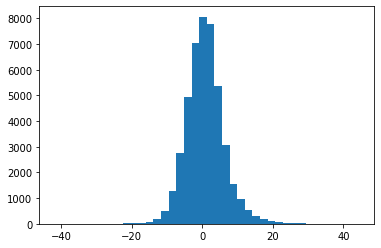

In [12]:
plt.hist(all_yaw_errors, bins=40)

wandb: Currently logged in as: synthesis-ai (use `wandb login --relogin` to force relogin)


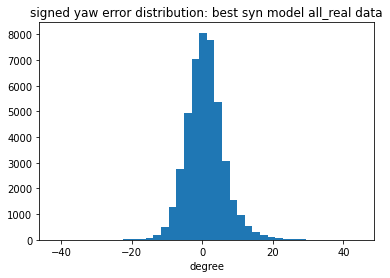

In [13]:
with wandb.init(project="64 best smodel_sdata2 all rdata signed errors") as run:
    plt.hist(all_yaw_errors, bins=40)
    plt.title("signed yaw error distribution: best syn model all_real data")
    plt.xlabel("degree")
    run.log({"data":wandb.Image(plt)})

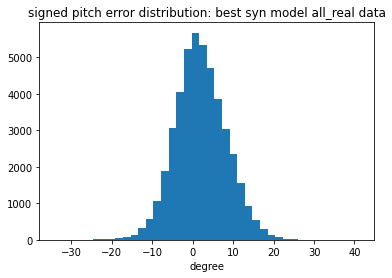

In [14]:
with wandb.init(project="64 best smodel_sdata2 all rdata signed errors") as run:
    plt.hist(all_pitch_errors, bins=40)
    plt.title("signed pitch error distribution: best syn model all_real data")
    plt.xlabel("degree")
    run.log({"data":wandb.Image(plt)})

In [15]:
with wandb.init(project="64 best smodel_sdata2 all rdata signed errors") as run:
    data = [[x, y] for (x, y) in zip(all_yaws, all_yaw_errors)]
    table = wandb.Table(data=data, columns = ["truth_degree", "error_degree"])
    wandb.log({"yaw_error_scatter" : wandb.plot.scatter(table, "truth_degree", "error_degree", title="yaw error vs ground truth")})


In [16]:
with wandb.init(project="64 best smodel_sdata2 all rdata signed errors") as run:
    data = [[x, y] for (x, y) in zip(all_pitches, all_pitch_errors)]
    table = wandb.Table(data=data, columns = ["truth_degree", "error_degree"])
    wandb.log({"pitch_error_scatter" : wandb.plot.scatter(table, "truth_degree", "error_degree", title="pitch error vs ground truth")})
